In [1]:
import socialforce
import pykalman
from collections import defaultdict, namedtuple
import json
import torch
import matplotlib.pyplot as plt

In [2]:
from socialforce.field_of_view import FieldOfView
from socialforce.potentials import PedPedPotential
import numpy as np
from scipy.interpolate import interp1d
from trajnetplusplustools import TrackRow, SceneRow, Reader

In [3]:
def final_l2(path1, path2):
    row1 = path1[-1]
    row2 = path2[-1]
    return np.linalg.norm((row2.x - row1.x, row2.y - row1.y))


def average_l2(path1, path2, n_predictions=25):
    assert len(path1) >= n_predictions
    assert len(path2) >= n_predictions
    path1 = path1[-n_predictions:]
    path2 = path2[-n_predictions:]

    return sum(np.linalg.norm((r1.x - r2.x, r1.y - r2.y))
               for r1, r2 in zip(path1, path2)) / n_predictions

In [4]:
def predict_kf(paths, predict_all=True, n_predict=25, obs_length=25):
    multimodal_outputs = {}
    neighbours_tracks = []

    primary = paths[0]
    start_frame = primary[obs_length-1].frame
    frame_diff = primary[1].frame - primary[0].frame
    first_frame = start_frame + frame_diff

    ## Primary Prediction
    if not predict_all:
        paths = paths[0:1]

    for i, path in enumerate(paths):
        path = paths[i]
        ped_id = path[0].car_id
        past_path = [t for t in path if t.frame <= start_frame]
        past_frames = [t.frame for t in path if t.frame <= start_frame]

        ## To consider agent or not consider.
        if start_frame not in past_frames:
            continue
        if len(past_path) < 2:
            continue

        initial_state_mean = [path[0].x, 0, path[0].y, 0]
        transition_matrix = [[1, 1, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, 1],
                             [0, 0, 0, 1]]

        observation_matrix = [[1, 0, 0, 0],
                              [0, 0, 1, 0]]

        kf = pykalman.KalmanFilter(transition_matrices=transition_matrix,
                                   observation_matrices=observation_matrix,
                                   transition_covariance=1e-5 * np.eye(4),
                                   observation_covariance=0.05**2 * np.eye(2),
                                   initial_state_mean=initial_state_mean)
        # kf.em([(r.x, r.y) for r in path[:9]], em_vars=['transition_matrices',
        #                                                'observation_matrices'])
        kf.em([(r.x, r.y) for r in past_path])
        observed_states, _ = kf.smooth([(r.x, r.y) for r in past_path])


        # sample predictions (first sample corresponds to last state)
        # average 5 sampled predictions
        predictions = None
        for _ in range(5):
            _, pred = kf.sample(n_predict + 1, initial_state=observed_states[-1])
            if predictions is None:
                predictions = pred
            else:
                predictions += pred
        predictions /= 5.0

        #write
        if i == 0:
            primary_track = predictions[1:]
        else:
            neighbours_tracks.append(np.array(predictions[1:]))

    ## Unimodal Ouput
    if len(np.array(neighbours_tracks)):
        neighbours_tracks = np.array(neighbours_tracks).transpose(1, 0, 2)

    multimodal_outputs[0] = primary_track, neighbours_tracks
    return multimodal_outputs


In [5]:
def predict_sf(input_paths, dest_dict=None, dest_type='interp', sf_params=[0.5, 2.1, 0.3],
            predict_all=True, n_predict=25, obs_length=25):
    
    pred_length = n_predict

    def init_states(input_paths, start_frame, dest_dict, dest_type):
        initial_state = []
        for i, _ in enumerate(input_paths):
            path = input_paths[i]
            ped_id = path[0].car_id
            past_path = [t for t in path if t.frame <= start_frame]
            past_frames = [t.frame for t in path if t.frame <= start_frame]
            future_path = [t for t in path if t.frame > start_frame]
            len_path = len(past_path)

            ## To consider agent or not consider.
            if start_frame in past_frames:
                curr = past_path[-1]

                ## Velocity
                if len_path >= 4:
                    stride = 3
                    prev = past_path[-4]
                else:
                    stride = len_path - 1
                    prev = past_path[-len_path]
                [v_x, v_y] = vel_state(prev, curr, stride)

                ## Destination
                if dest_type == 'true':
                    if dest_dict is not None:
                        [d_x, d_y] = dest_dict[ped_id]
                    else:
                        raise ValueError
                elif dest_type == 'interp':
                    [d_x, d_y] = dest_state(past_path, len_path)
                elif dest_type == 'vel':
                    [d_x, d_y] = [pred_length*v_x, pred_length*v_y]
                elif dest_type == 'pred_end':
                    [d_x, d_y] = [future_path[-1].x, future_path[-1].y]
                else:
                    raise NotImplementedError

                ## Initialize State
                initial_state.append([curr.x, curr.y, v_x, v_y, d_x, d_y])
        return np.array(initial_state)

    def vel_state(prev, curr, stride):
        if stride == 0:
            return [0, 0]
        diff = np.array([curr.x - prev.x, curr.y - prev.y])
        theta = np.arctan2(diff[1], diff[0])
        speed = np.linalg.norm(diff) / (stride * 0.4)
        return [speed*np.cos(theta), speed*np.sin(theta)]

    def dest_state(path, length):
        if length == 1:
            return [path[-1].x, path[-1].y]
        x = [t.x for t in path]
        y = [t.y for t in path]
        time = list(range(length))
        f = interp1d(x=time, y=[x, y], fill_value='extrapolate')
        return f(time[-1] + pred_length)

    multimodal_outputs = {}
    primary = input_paths[0]
    neighbours_tracks = []
    frame_diff = primary[1].frame - primary[0].frame
    start_frame = primary[obs_length-1].frame
    first_frame = primary[obs_length-1].frame + frame_diff

    # initialize
    initial_state = init_states(input_paths, start_frame, dest_dict, dest_type)

    fps = 25
    sampling_rate = int(fps / 1)

#     if len(initial_state) != 0:
#         # run  
#         ped_ped = PedPedPotential(v0=sf_params[1], sigma=sf_params[2])
#         field_of_view = FieldOfView()
#         s = socialforce.Simulator(ped_ped=ped_ped, field_of_view=field_of_view,
#                                   delta_t=1./fps, tau=sf_params[0])
#         states = np.stack([s.step().state.copy() for _ in range(pred_length*sampling_rate)])
#         ## states : pred_length x num_ped x 7
#         states = np.array([s for num, s in enumerate(states) if num % sampling_rate == 0])
        
        
    if len(initial_state) != 0:
        # 准备参数和模拟器
        ped_ped = PedPedPotential(v0=sf_params[1], sigma=sf_params[2])
        field_of_view = FieldOfView()
        s = socialforce.Simulator(ped_ped=ped_ped, field_of_view=field_of_view, 
                                  delta_t=1./fps, tau=sf_params[0])

        # 确保initial_state是正确的数据类型和格式
        initial_state = torch.tensor(initial_state, dtype=torch.float32)  # 以您的实际initial_state来修改

        # 执行模拟
        number_of_steps = pred_length * sampling_rate  # 根据您的需求修改
        result_states = s.run(initial_state, number_of_steps)

        # 如果您需要的states是numpy array类型，您可以这样转换：
        states = result_states.detach().numpy()

        # 您可以根据需要处理和过滤模拟的结果
        states = np.array([s for num, s in enumerate(states) if num % sampling_rate == 0])

    else:
        ## Stationary
        past_path = [t for t in input_paths[0] if t.frame == start_frame]
        states = np.stack([[[past_path[0].x, past_path[0].y]] for _ in range(pred_length)])

    # predictions
    primary_track = states[:, 0, 0:2]
    neighbours_tracks = states[:, 1:, 0:2]

    ## Primary Prediction Only
    if not predict_all:
        neighbours_tracks = []

    # Unimodal Prediction
    multimodal_outputs[0] = primary_track, neighbours_tracks
    return multimodal_outputs

In [6]:
class Evaluator(object):
    def __init__(self, scenes, dest_dict=None, params=None, args=None):
        self.scenes = scenes
        self.dest = dest_dict
        self.params = params

        self.average_l2 = {'N': len(scenes)}
        self.final_l2 = {'N': len(scenes)}

        self.args = args

    def aggregate(self, name, predictor, dest_type='true'):
        print('evaluating', name)

        average = 0.0
        final = 0.0

        # pred_dict = {}
        # pred_neigh_dict = {}
        # n = 0

        for _, paths in enumerate(self.scenes):
            ## select only those trajectories which interactions ##
            # rows = trajnetplusplustools.Reader.paths_to_xy(paths)
            # neigh_paths = paths[1:]
            # interaction_index = collision_avoidance(rows)
            # neigh = list(compress(neigh_paths, interaction_index))
            # paths = [paths[0]] + neigh

            if 'kf' in name:
                prediction, neigh = predictor(paths, n_predict=self.args.pred_length, obs_length=self.args.obs_length)[0]
            if 'sf' in name:
                prediction, neigh = predictor(paths, self.dest, dest_type, self.params['sf'])[0]
            # if 'orca' in name:
            #     prediction, neigh = predictor(paths, self.dest, dest_type, self.params['orca'], args=self.args)[0]

            ## visualize predictions ##
            # pred_dict['pred'] = prediction
            # pred_neigh_dict['pred'] = neigh
            # n += 1
            # if n < 17:
            #     with show.predicted_paths(paths, pred_dict, pred_neigh_paths=pred_neigh_dict):
            #         pass
            # else:
            #     break

            ## Convert numpy array to Track Rows ##
            ## Extract 1) first_frame, 2) frame_diff 3) ped_ids for writing predictions
            observed_path = paths[0]
            frame_diff = observed_path[1].frame - observed_path[0].frame
            first_frame = observed_path[self.args.obs_length-1].frame + frame_diff
            ped_id = observed_path[0].car_id

            ## make Track Rows
            prediction = [TrackRow(first_frame + i * frame_diff, ped_id, prediction[i, 0], prediction[i, 1], 0)
                          for i in range(len(prediction))]

            average_l2_a = average_l2(paths[0], prediction)
            final_l2_a = final_l2(paths[0], prediction)
            print(average_l2_a)

            # aggregate
            average += average_l2_a
            final += final_l2_a

        average /= len(self.scenes)
        final /= len(self.scenes)

        self.average_l2[name] = average
        self.final_l2[name] = final

        return self

    def result(self):
        return self.average_l2, self.final_l2

In [7]:
def eval(input_file, dest_file, simulator, params, type_ids, args):
    print('dataset', input_file)

    reader = Reader(input_file, scene_type='paths')
    scenes = [s for _, s in reader.scenes()][0:5]

    dest_dict = None
    if dest_file is not None:
        dest_dict = pickle.load(open(dest_file, "rb"))

    evaluator = Evaluator(scenes, dest_dict, params, args)
    
    
    ## Evaluate all
    if simulator == 'all':
        for dest_type in ['interp']:
            # evaluator.aggregate('orca' + dest_type, orca.predict, dest_type)
            evaluator.aggregate('sf' + dest_type, predict_sf, dest_type)
            evaluator.aggregate('kf', predict_kf)

    # Social Force only
    elif simulator == 'sf':
        for dest_type in ['interp']:
            evaluator.aggregate('sf' + dest_type, predict_sf, dest_type)

    # Kalman only
    elif simulator == 'kf':  
        evaluator.aggregate('kf', predict_kf)

    return evaluator.result()

In [8]:
class Args:
    obs_length = 25
    pred_length = 25
    simulator = 'sf'
    tau = 0.5
    vo = 2.1
    sigma = 0.3
    min_dist = 4
    react_time = 4
    radius = 0.6

args = Args()


In [9]:
def main(args):
    params = {}
    if args.simulator == 'sf' or 'all':
        params['sf'] = [args.tau, args.vo, args.sigma]
    # if args.simulator == 'orca' or 'all':
    #     params['orca'] = [args.min_dist, args.react_time, args.radius]

    print(params)
    datasets = [
        'DATA_BLOCK/ind/test/04_tracks.ndjson'
    ]
    print(datasets)

    dest_dicts = None

    filtered_ids = {}


    results = {}
    for i, dataset in enumerate(datasets):
        type_ids = None
        dataset_name = dataset.replace('DATA_BLOCK/ind/test/', '').replace('.ndjson', '')
        if dataset_name in filtered_ids:
            type_ids = filtered_ids[dataset_name]       
        results[dataset_name] = eval(dataset, dest_dicts, args.simulator, params, type_ids, args)

    if args.simulator == 'all':
        print('## Average L2 [m]')
        print('{dataset:>30s} | N | SF | KF '.format(dataset=''))
        print(results)
        for dataset, (r, _) in results.items():
            print(
                '{dataset:>30s}'
                ' | {r[N]:>4}'
                ' | {r[orcainterp]:.2f}'
                ' | {r[sfinterp]:.2f}'
                ' | {r[kf]:.2f}'.format(dataset=dataset, r=r)
            )
        print('')

        print('## Final L2 [m]')
        print('{dataset:>30s} | N | SF | KF '.format(dataset=''))
        for dataset, (_, r) in results.items():
            print(
                '{dataset:>30s}'
                ' | {r[N]:>4}'
                ' | {r[orcainterp]:.2f}'
                ' | {r[sfinterp]:.2f}'
                ' | {r[kf]:.2f}'.format(dataset=dataset, r=r)
            )

In [10]:
main(args)

{'sf': [0.5, 2.1, 0.3]}
['DATA_BLOCK/ind/test/04_tracks.ndjson']
dataset DATA_BLOCK/ind/test/04_tracks.ndjson
evaluating sfinterp
0.08287063810155287
0.10562301204240972
0.13029267039175735
0.12797542256845154


KeyboardInterrupt: 

In [20]:
def Traj_plot(scene_index, scenes, simulator,criterion):
    if simulator == 'sf':
        prediction, neigh = predict_sf(scenes[scene_index], None, 'interp', params['sf'])[0]
    elif simulator == 'kf':
        prediction, neigh = predict_kf(scenes[scene_index], n_predict=25, obs_length=25)[0]
    else:
        for simulator in ['sf', 'kf']:
            Traj_plot(scene_index, scenes, simulator, criterion)
        return 0
    train_scale=np.array([2, 0.5, 0.01, 0.02])
    xy = np.array([[row.x, row.y] for row in scenes[scene_index][0]])
    
    train_scale = train_scale[:2]
    
    observed = xy[:25]
    truth = xy[25:50]
    
    
    # Calculate the loss
    observed_path = scenes[scene_index][0]
    frame_diff = observed_path[1].frame - observed_path[0].frame
    first_frame = observed_path[24].frame + frame_diff
    ped_id = observed_path[0].car_id

    ## make Track Rows
    prediction_list = [TrackRow(first_frame + i * frame_diff, ped_id, prediction[i, 0], prediction[i, 1], 0)
                  for i in range(len(prediction))]

    train_loss = criterion(scenes[scene_index][0], prediction_list)
#     train_loss = torch.tensor(0)
    # Convert to numpy for plotting
    observed_np = (observed * train_scale)
    pred_np = (prediction * train_scale)

    truth_np = (truth * train_scale)
    
#     pred_full_np = (pred_full * train_scale.unsqueeze(0).unsqueeze(0)).cpu().numpy()
#     truth_full_np = (truth_full * train_scale.unsqueeze(0).unsqueeze(0)).cpu().numpy()

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(observed_np[:, 0], observed_np[:, 1], 'b--', linewidth=2, label='Traj_observed')
    plt.scatter(observed_np[:, 0], observed_np[:, 1], c='b', s=5)
    
    plt.plot(pred_np[:, 0], pred_np[:, 1], 'g-', label='Traj_pred')
    plt.scatter(pred_np[:, 0], pred_np[:, 1], c='g', s=5)

    plt.plot(truth_np[:, 0], truth_np[:, 1], 'r-', label='Traj_target')
    plt.scatter(truth_np[:, 0], truth_np[:, 1], c='r', s=5)

    plt.scatter(observed_np[-1, 0], observed_np[-1, 1], marker='^', s=100, c='black', label='Current State')
    train_loss = train_loss.item()
    plt.text(0.95, 0.01, f'simulator:{simulator}\n'f'Loss: {train_loss:.4f}', verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)

    
    plt.axis('equal') 
    plt.legend()
    plt.savefig('Traj_plot.png')
    plt.show()



In [17]:
params = {}
datasets = [
        'DATA_BLOCK/ind/test/04_tracks.ndjson'
    ]

reader = Reader(datasets[0], scene_type='paths')
scenes = [s for _, s in reader.scenes()]
params['sf'] = [args.tau, args.vo, args.sigma]

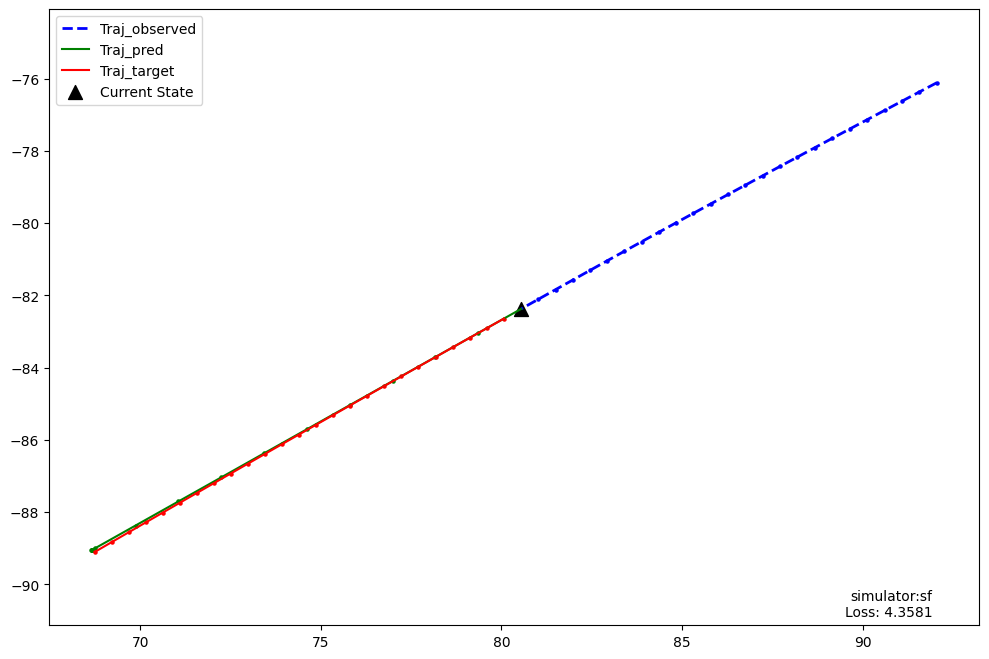

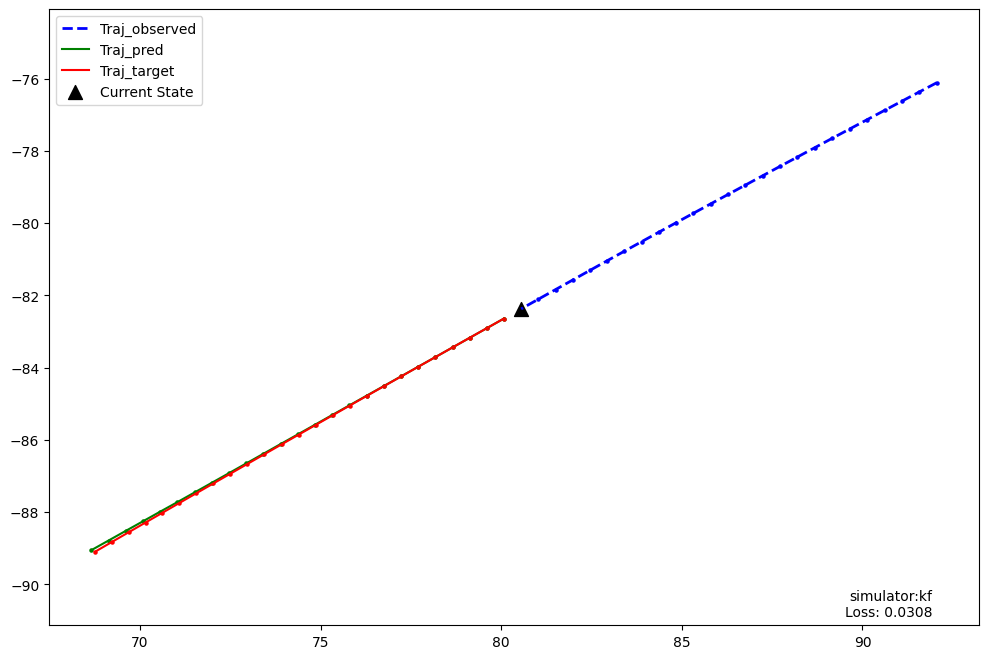

0

In [39]:
Traj_plot(280, scenes, 'all',average_l2)#350

In [14]:
scene = scenes[350][0]
xy = np.array([[row.x, row.y] for row in scene])
print(xy.shape)

(50, 2)


In [27]:
def calculate_average_loss(scenes, simulator, criterion):
    total_loss = 0
    total_scenes = len(scenes)
    
    for scene_index in range(total_scenes):
        if simulator == 'sf':
            prediction, neigh = predict_sf(scenes[scene_index], None, 'interp', params['sf'])[0]
        elif simulator == 'kf':
            prediction, neigh = predict_kf(scenes[scene_index], n_predict=25, obs_length=25)[0]
        else:
            raise ValueError(f"Invalid simulator: {simulator}")
        
        xy = np.array([[row.x, row.y] for row in scenes[scene_index][0]])
        observed = xy[:25]
        truth = xy[25:50]

        observed_path = scenes[scene_index][0]
        frame_diff = observed_path[1].frame - observed_path[0].frame
        first_frame = observed_path[24].frame + frame_diff
        ped_id = observed_path[0].car_id

        ## make Track Rows
        prediction_list = [TrackRow(first_frame + i * frame_diff, ped_id, prediction[i, 0], prediction[i, 1], 0)
                      for i in range(len(prediction))]
        
        scene_loss = criterion(scenes[scene_index][0], prediction_list)
        total_loss += scene_loss.item()


    average_loss = total_loss / total_scenes
    return average_loss


In [33]:
calculate_average_loss(scenes, 'kf', average_l2)

5.587027261313371

In [34]:
calculate_average_loss(scenes, 'sf', average_l2)

7.357729284610144